In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import time
import datetime
import geocoder
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',50)
pd.set_option('max_colwidth',200)
%matplotlib inline
import requests
import json
import urllib
from urllib.request import urlopen

def getGeoForAddress(address):
    add = urllib.parse.quote(address)
    addressUrl = "https://maps.googleapis.com/maps/api/geocode/json?address=" + add + '&key='
    res = requests.get(addressUrl)
    js = json.loads(res.text)
    if js.get('results'):
        lat = js.get('results')[0]['geometry']['location']['lat']
        lng = js.get('results')[0]['geometry']['location']['lng']
    else:
        lat = ''
        lng = ''
    return [lat, lng]
def ngram(text, n=3, pad=True):
    text = text.strip()
    if pad:
        text = " %s " % text
    return set([text[i:i+n] for i in range(len(text)-n+1)])
    
def create_ngram(text1, text2, n=3, pad=True):
    return ngram(text1, n=n, pad=pad), ngram(text2, n=n, pad=pad)

def tversky_index(text1, text2, a=None, b=None, q=3, pad=True):
    text1, text2 = create_ngram(text1, text2, n=q, pad=pad)
    agree_tot = len(text1.intersection(text2))
    v1 = len(text1) - agree_tot
    v2 = len(text2) - agree_tot
    
    if a != None and b != None:
        a = a/float(a+b)
        b = b/float(a+b)
    elif a <= 1.0 and a >= 0.0:
        b = 1-a
    elif b <= 1.0 and b >= 0.0:
        a = 1-b
    else:
        a = 0.5
        b = 0.5        
    return float(agree_tot)/(agree_tot+a*v1+b*v2)
# incoPat為申請人list
def fuzzy(incoPat,indus):
    corptype = ['有限','公司','责任','集团','股份','控股']
    text1 = incoPat
    text2 = indus
    incoPat_nor = []   
    for text in text1:
        for i in corptype:
            if i in text:
                text = re.sub(i,'',text)
        incoPat_nor.append(text)
    for i in corptype:
        if i in text2:
            text2 = re.sub(i,'',text2)
    similar = []
    for text in incoPat_nor:
        dice = tversky_index(text,text2, a=0.5, q=min(2,len(text),len(text2)), pad=False)
        if dice>0.7:
            similar.append([incoPat[incoPat_nor.index(text)],dice])
        else:
            pass
    if len(similar)>0:
        return similar[[k[1] for k in similar].index(max([i[1] for i in similar]))][0]
    else:
        return indus
city_code = pd.read_excel('C:/Users/user/Dropbox/paper/科技園區/China/省地縣碼對照.xls')
city_code = city_code[~city_code['代碼'].isnull()].drop(['标注','说明'],axis=1)
city_code['代碼_str'] = city_code['代碼'].apply(lambda x:str(int(x)))
city_code = city_code.drop('代碼',axis=1)

# 江蘇資料整合

In [2]:
df1 = pd.read_excel(r'E:\paper\專利資料-新型&授權\新型授權-江蘇1.xls')
df2 = pd.read_excel(r'E:\paper\專利資料-新型&授權\新型授權-江蘇2.xls')
df3 = pd.read_excel(r'E:\paper\專利資料-新型&授權\新型授權-江蘇3.xls')
df4 = pd.read_excel(r'E:\paper\專利資料-新型&授權\新型授權-江蘇4.xls')
df5 = pd.read_excel(r'E:\paper\專利資料-新型&授權\新型授權-江蘇5.xls')
df6 = pd.read_excel(r'E:\paper\專利資料-新型&授權\新型授權-江蘇6.xls')
df7 = pd.read_excel(r'E:\paper\專利資料-新型&授權\新型授權-江蘇7.xls')
df8 = pd.read_excel(r'E:\paper\專利資料-新型&授權\新型授權-江蘇8.xls')
df9 = pd.read_excel(r'E:\paper\專利資料-新型&授權\新型授權-江蘇9.xls')
df10 = pd.read_excel(r'E:\paper\專利資料-新型&授權\新型授權-江蘇10.xls')
df11 = pd.read_excel(r'E:\paper\專利資料-新型&授權\新型授權-江蘇11.xls')
df12 = pd.read_excel(r'E:\paper\專利資料-新型&授權\新型授權-江蘇12.xls')
df13 = pd.read_excel(r'E:\paper\專利資料-新型&授權\新型授權-江蘇13.xls')
df14 = pd.read_excel(r'E:\paper\專利資料-新型&授權\新型授權-江蘇14.xls')
df15 = pd.read_excel(r'E:\paper\專利資料-新型&授權\新型授權-江蘇15.xls')

patent_df = pd.concat([df1,df2,df3,df4,df5,df6,df7,df8,df9,df10,df11,df12,df13,df14,df15],ignore_index=True,sort=True)

In [3]:
patent_df.shape

(709591, 38)

In [4]:
patent_df['申请人地址'].fillna('',inplace=True)
patent_df = patent_df[patent_df['申请人地址']!='']

In [5]:
patent_df.shape

(709591, 38)

In [3]:
#for PC
patent_df = patent_df[patent_df['专利类型']=='发明授权']
patent_df = patent_df[patent_df['申请人地址'].map(lambda x:len(re.findall(r'\D+[\s\S]+',x)))==1]
patent_df['申请人地址'] = patent_df['申请人地址'].map(lambda x:re.findall(r'\D+[\s\S]+',x)[0])
patent_df['申请人地址'] = patent_df['申请人地址'].map(lambda x:re.sub(r"\s+", "",x))
patent_df_firm = patent_df[patent_df['申请人类型'].str.contains('企业')]
applicant = patent_df_firm['申请人'].str.split(';',expand=True).stack().reset_index(level=1,drop=True).rename('申请人2')
patent_df_firm = patent_df_firm.join(applicant)
patent_df_firm['類別'] = patent_df_firm['申请人类型'].map(lambda x:x.strip().split('  '))
patent_df_firm = patent_df_firm[~patent_df_firm['标题'].duplicated()]
patent_df_firm['申请人类型'] = patent_df_firm.apply(lambda x:x['類別'][0],axis=1)
patent_df_firm = patent_df_firm[patent_df_firm['申请人类型']=='企业'].sort_values('申请日')
patent_df_firm.drop(['類別','申请人'],axis=1,inplace=True)
patent_df_firm.rename(columns={'申请人2':'申请人'},inplace=True)
patent_df_firm = patent_df_firm[patent_df_firm['申请日']<datetime.datetime.strptime('2013-01-01','%Y-%m-%d')]
patent_df_firm.drop_duplicates('申请人地址', keep='last', inplace=True)
patent_df_firm.drop_duplicates('申请人', keep='last', inplace=True)

firm_df = pd.read_csv(r'E:\paper\Firm csv\firm_data_2012.csv')
firm_gd = firm_df[firm_df['區域代碼'].astype(str).str.contains(r'32\d{10}')==True]
firm_gd = firm_gd.loc[:,['法人代碼','企業名稱','地址','區域代碼','行業代碼']]
firm_gd['區域代碼_str'] = firm_gd['區域代碼'].astype(str).map(lambda x:x[0:6])
firm_gd = pd.merge(firm_gd,city_code,left_on='區域代碼_str',right_on='代碼_str',how='left')
firm_gd['名稱'].fillna('',inplace=True)
firm_gd['市級'].fillna('',inplace=True)
firm_gd['省份'].fillna('',inplace=True)
firm_gd['地址'].fillna('',inplace=True)
firm_gd['地址'] = firm_gd['地址'].map(lambda x:re.sub(r"\s+", "",x))
firm_gd['地址'] = firm_gd.apply(lambda x:re.sub(x['省份'],"",x['地址']),axis=1)
firm_gd['地址'] = firm_gd.apply(lambda x:re.sub(x['市級'],"",x['地址']),axis=1)
firm_gd['地址'] = firm_gd.apply(lambda x:re.sub(x['名稱'],"",x['地址']),axis=1)
firm_gd['地址'] = firm_gd['省份']+firm_gd['市級']+firm_gd['名稱']+firm_gd['地址']
firm_gd.drop(['省份','市級','名稱','代碼_str'],axis=1,inplace=True)
firm_gd.dropna(subset=['企業名稱'],inplace=True)

D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (0,3,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
patent_df_firm = patent_df_firm[patent_df_firm['申请日']>datetime.datetime.strptime('2007-12-31','%Y-%m-%d')]
incoPat = list(patent_df_firm['申请人'])

In [8]:
patent_df_firm.shape

(36773, 38)

In [9]:
firm_gd.shape

(43954, 6)

## 模糊比對待跑

In [10]:
firm_gd['name_模糊比對'] = firm_gd['企業名稱'].map(lambda x:fuzzy(incoPat,x))

KeyboardInterrupt: 

In [12]:
firm_gd.to_excel(r'E:\paper\清理結果-新型&授權\江蘇_廠商.xlsx')

# 非模糊比對

In [13]:
merge_df = firm_gd.merge(patent_df_firm,left_on='企業名稱',right_on='申请人',how='outer')
merge_df.fillna('',inplace=True)
print(merge_df[(merge_df['企業名稱']!='')&(merge_df['申请人']!='')].shape)
print(merge_df.shape)

(9639, 44)
(71088, 44)


In [14]:
merge_df['name'] = merge_df.apply(lambda x:x['申请人'] if x['申请人']!='' else x['企業名稱'],axis=1)
merge_df['address'] = merge_df.apply(lambda x:x['申请人地址'] if x['申请人地址']!='' else x['地址'],axis=1)
merge_df_clean = merge_df[merge_df['address'].str.contains(r'\w+(街|道|路|巷|村|小区|园区|社区)')]
merge_df_clean['address'] = merge_df_clean['address'].map(lambda x: x+'号' if ((x[-1].isdigit()) and (re.match(r'\w+[街道路巷]',x))) else x)
merge_df_clean['完整地址'] = merge_df_clean['address'].map(lambda x:1 if re.compile(r'\w+[街道路巷]\S+号').search(x) else 0)
merge_df_clean.loc[:,'lat'] = 0
merge_df_clean.loc[:,'lnt'] = 0
print(merge_df_clean[merge_df_clean['完整地址']==1].shape)
print(merge_df_clean.shape)

D:\Anaconda\lib\site-packages\pandas\core\strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


(33664, 49)
(57985, 49)


D:\Anaconda\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
D:\Anaconda\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [15]:
merge_df_clean.to_excel(r'E:\paper\清理結果-新型&授權\江蘇_結果.xlsx')

# merge舊資料

In [4]:
merge_df = firm_gd.merge(patent_df_firm,left_on='企業名稱',right_on='申请人',how='outer')
merge_df.fillna('',inplace=True)
print(merge_df[(merge_df['企業名稱']!='')&(merge_df['申请人']!='')].shape)
print(merge_df.shape)
merge_df['name'] = merge_df.apply(lambda x:x['申请人'] if x['申请人']!='' else x['企業名稱'],axis=1)
merge_df['address'] = merge_df.apply(lambda x:x['申请人地址'] if x['申请人地址']!='' else x['地址'],axis=1)
merge_df = merge_df[merge_df['address']!='']
merge_df_clean = merge_df
merge_df_clean['address'] = merge_df_clean['address'].map(lambda x: x+'号' if ((x[-1].isdigit()) and (re.match(r'\w+[街道路巷]',x))) else x)
merge_df_clean['完整地址'] = merge_df_clean['address'].map(lambda x:1 if re.compile(r'\w+[街道路巷]\S+号').search(x) else 0)
merge_df_clean.loc[:,'lat'] = 0
merge_df_clean.loc[:,'lnt'] = 0
print(merge_df_clean[merge_df_clean['完整地址']==1].shape)
print(merge_df_clean.shape)

(4603, 44)
(52673, 44)
(20866, 49)
(52666, 49)


In [5]:
done_data = pd.read_excel(r'E:\paper\清理結果-園區內外\江蘇_結果.xlsx')
done_data.columns

Index(['Unnamed: 0', '法人代碼', '企業名稱', '地址', '區域代碼', '行業代碼', '區域代碼_str', 'CPC',
       'IPC', 'inpadoc同族', 'inpadoc同族个数', '专利寿命（月）', '专利类型', '中国申请人区县',
       '中国申请人地市', '优先权信息', '公开国别', '公开（公告）号', '公开（公告）日', '发明人', '合享价值度',
       '同族国家', '失效日', '序号', '引证专利', '引证科技文献', '扩展同族', '扩展同族个数', '文献页数',
       '权利要求数量', '标准化申请人', '标题', '申请人', '申请人国别代码', '申请人地址', '申请人省市代码', '申请人类型',
       '申请号', '申请日', '简单同族', '简单同族个数', '被引证专利', '被引证国别(forward)', '被引证次数',
       '链接到incoPat', 'name', 'address', '完整地址', 'lat', 'lnt', '南京', '蘇州', '無錫',
       '常州', '蘇州工業園', '崑山', '江陰', '武進', '泰州醫藥', '徐州', '專利數', '早期園區', '近期園區'],
      dtype='object')

In [6]:
merge_df_clean.drop(['lat','lnt'],axis=1,inplace=True)
merge_df_clean = merge_df_clean.merge(done_data[['name','lat','lnt','南京','蘇州','無錫','常州','蘇州工業園','崑山','江陰','武進','泰州醫藥','徐州','專利數','早期園區','近期園區']],left_on='name',right_on='name',how='left')
merge_df_clean['lat'].fillna('',inplace=True)
merge_df_clean[merge_df_clean['lat']==''].shape

(12791, 62)

In [7]:
merge_df_clean.to_excel(r'E:\paper\清理結果-新\江蘇_結果.xlsx')

# 模糊比對

In [ ]:
merge_df_fuzzy = firm_gd.merge(patent_df_firm,left_on='name_模糊比對',right_on='申请人',how='outer')
merge_df_fuzzy.fillna('',inplace=True)
merge_df_fuzzy.drop_duplicates(['name_模糊比對','申请人'], keep='last', inplace=True)
print(merge_df_fuzzy[(merge_df_fuzzy['申请人']!='')&(merge_df_fuzzy['企業名稱']!='')].shape)
print(merge_df_fuzzy.shape)

In [ ]:
merge_df_fuzzy['name'] = merge_df_fuzzy.apply(lambda x:x['申请人'] if x['申请人']!='' else x['企業名稱'],axis=1)
merge_df_fuzzy['address'] = merge_df_fuzzy.apply(lambda x:x['申请人地址'] if x['申请人地址']!='' else x['地址'],axis=1)
merge_df_fuzzy_clean = merge_df_fuzzy[merge_df_fuzzy['address'].str.contains(r'\w+(街|道|路|巷|村|小区|园区|社区)')]
merge_df_fuzzy_clean['address'] = merge_df_fuzzy_clean['address'].map(lambda x: x+'号' if ((x[-1].isdigit()) and (re.match(r'\w+[街道路巷]',x))) else x)
merge_df_fuzzy_clean['完整地址'] = merge_df_fuzzy_clean['address'].map(lambda x:1 if re.compile(r'\w+[街道路巷]\S+号').search(x) else 0)
merge_df_fuzzy_clean.loc[:,'lat'] = 0
merge_df_fuzzy_clean.loc[:,'lnt'] = 0
print(merge_df_fuzzy_clean[merge_df_fuzzy_clean['完整地址']==1].shape)
print(merge_df_fuzzy_clean.shape)

In [ ]:
merge_df_fuzzy_clean.to_excel(r'E:\paper\清理結果-新型&授權\江蘇_模糊結果.xlsx')

# 定位

In [2]:
merge_df_clean = pd.read_excel(r'E:\paper\清理結果-新型&授權\江蘇_結果.xlsx',index_col=0)

In [3]:
merge_df_clean = pd.read_excel(r'E:\paper\清理結果-新\江蘇_結果.xlsx',index_col=0)
merge_df_clean.fillna('',inplace=True)
merge_df_clean[merge_df_clean['lat']==''].shape

(12791, 62)

In [4]:
for i in merge_df_clean[merge_df_clean['lat']==''].index:
    address = merge_df_clean.loc[i,'address']
    g = getGeoForAddress(address)
    merge_df_clean.loc[i,'lat'] = g[0]
    merge_df_clean.loc[i,'lnt'] = g[1]

In [17]:
print(merge_df_clean.shape)
print(merge_df_clean[merge_df_clean['lat']==''].shape)

(52666, 62)
(868, 62)


In [18]:
merge_df_clean.to_excel(r'E:\paper\清理結果-新\江蘇_結果.xlsx')

# 作圖

In [3]:
from geopy.distance import geodesic
def how_far(a,b):
    try:
        return geodesic(a,b).kilometers
    except:
        return np.nan
applicant = patent_df['申请人'].str.split(';',expand=True).stack().reset_index(level=1,drop=True).rename('申请人2')
applicant = applicant.map(lambda x:x.strip())
patent_df_new = patent_df.join(applicant)
patent_count = patent_df_new.groupby('申请人2')['标题'].count().rename('專利數')

In [4]:
patent_count.sort_values()

申请人2
(中外合资)泰州宏达化纤绳网有限公司        1
武进市芙蓉防腐材料厂                1
武进市英特曼电子电器有限公司            1
武进市范群干燥设备厂                1
武进市西夏墅燃气安全设备厂             1
                      ...  
江苏大学                   5201
中国矿业大学                 5713
鸿海精密工业股份有限公司           8134
富士康(昆山)电脑接插件有限公司       8373
东南大学                  10088
Name: 專利數, Length: 109816, dtype: int64

In [5]:
merge_df = pd.read_excel(r'E:\paper\清理結果-新型&授權\江蘇_結果.xlsx',index_col=0)
target1 = (32.16916,118.70646)
merge_df['南京'] = merge_df.apply(lambda x:how_far(target1,(x['lat'],x['lnt'])),axis=1)
target2 = (31.29696,120.55688)
merge_df['蘇州'] = merge_df.apply(lambda x:how_far(target2,(x['lat'],x['lnt'])),axis=1)
target3 = (31.54877,120.35393)
merge_df['無錫'] = merge_df.apply(lambda x:how_far(target3,(x['lat'],x['lnt'])),axis=1)
target4 = (31.83028,119.97137)
merge_df['常州'] = merge_df.apply(lambda x:how_far(target4,(x['lat'],x['lnt'])),axis=1)
target5 = (31.31961,120.77058)
merge_df['蘇州工業園'] = merge_df.apply(lambda x:how_far(target5,(x['lat'],x['lnt'])),axis=1)
target6 = (31.32733,120.88654)
merge_df['崑山'] = merge_df.apply(lambda x:how_far(target6,(x['lat'],x['lnt'])),axis=1)
target7 = (31.9199,120.30443)
merge_df['江陰'] = merge_df.apply(lambda x:how_far(target7,(x['lat'],x['lnt'])),axis=1)
target8 = (31.66728,119.95946)
merge_df['武進'] = merge_df.apply(lambda x:how_far(target8,(x['lat'],x['lnt'])),axis=1)
target9 = (32.39439,119.90592)
merge_df['泰州醫藥'] = merge_df.apply(lambda x:how_far(target9,(x['lat'],x['lnt'])),axis=1)
target10 = (34.19027,117.18842)
merge_df['徐州'] = merge_df.apply(lambda x:how_far(target10,(x['lat'],x['lnt'])),axis=1)
merge_df = merge_df.merge(patent_count,left_on='name',right_on='申请人2',how='left')
merge_df['專利數'].fillna(0,inplace=True)

In [6]:
merge_df = pd.read_excel(r'E:\paper\清理結果-新\江蘇_結果.xlsx',index_col=0)
merge_df.fillna('',inplace=True)
merge_df.drop('專利數',axis=1,inplace=True)
target1 = (32.16916,118.70646)
target2 = (31.29696,120.55688)
target3 = (31.54877,120.35393)
target4 = (31.83028,119.97137)
target5 = (31.31961,120.77058)
target6 = (31.32733,120.88654)
target7 = (31.9199,120.30443)
target8 = (31.66728,119.95946)
target9 = (32.39439,119.90592)
target10 = (34.19027,117.18842)

for i in merge_df[merge_df['南京']==''].index:
    merge_df.loc[i,'南京'] = how_far(target1,(merge_df.loc[i,'lat'],merge_df.loc[i,'lnt']))
    merge_df.loc[i,'蘇州'] = how_far(target2,(merge_df.loc[i,'lat'],merge_df.loc[i,'lnt']))
    merge_df.loc[i,'無錫'] = how_far(target3,(merge_df.loc[i,'lat'],merge_df.loc[i,'lnt']))
    merge_df.loc[i,'常州'] = how_far(target4,(merge_df.loc[i,'lat'],merge_df.loc[i,'lnt']))
    merge_df.loc[i,'蘇州工業園'] = how_far(target5,(merge_df.loc[i,'lat'],merge_df.loc[i,'lnt']))
    merge_df.loc[i,'崑山'] = how_far(target6,(merge_df.loc[i,'lat'],merge_df.loc[i,'lnt']))
    merge_df.loc[i,'江陰'] = how_far(target7,(merge_df.loc[i,'lat'],merge_df.loc[i,'lnt']))
    merge_df.loc[i,'武進'] = how_far(target8,(merge_df.loc[i,'lat'],merge_df.loc[i,'lnt']))
    merge_df.loc[i,'泰州醫藥'] = how_far(target9,(merge_df.loc[i,'lat'],merge_df.loc[i,'lnt']))
    merge_df.loc[i,'徐州'] = how_far(target10,(merge_df.loc[i,'lat'],merge_df.loc[i,'lnt']))
merge_df = merge_df.merge(patent_count,left_on='name',right_on='申请人2',how='left')
merge_df['專利數'].fillna(0,inplace=True)

In [7]:
merge_df['早期園區'] = merge_df.apply(lambda x:1 if ((x['南京']<10)or(x['蘇州']<10)or(x['無錫']<10)or(x['常州']<10)or(x['蘇州工業園']<10)) else 0,axis=1)
merge_df['近期園區'] = merge_df.apply(lambda x:1 if ((x['崑山']<10)or(x['江陰']<10)or(x['武進']<10)or(x['泰州醫藥']<10)or(x['徐州']<10)) else 0,axis=1)

In [11]:
merge_df.to_excel(r'E:\paper\清理結果-新園區內外\江蘇_結果.xlsx')

In [8]:
print(merge_df.shape)
print(len(merge_df[merge_df['專利數']==0]['專利數'])/len(merge_df['專利數']))
print(len(merge_df[merge_df['專利數']>=100]['專利數'])/len(merge_df['專利數']))

(52666, 62)
0.6277864276762997
0.007557057684274484


In [9]:
merge_df.groupby('專利數')['IPC'].count()

專利數
0.0       33063
1.0        2658
2.0        1829
3.0        1242
4.0        1035
5.0         795
6.0         838
7.0         850
8.0         821
9.0         692
10.0        688
11.0        570
12.0        543
13.0        491
14.0        477
15.0        423
16.0        351
17.0        381
18.0        328
19.0        290
20.0        291
21.0        243
22.0        201
23.0        204
24.0        179
25.0        150
26.0        154
27.0        155
28.0        141
29.0        115
30.0        101
31.0        101
32.0        100
33.0         88
34.0         82
35.0         83
36.0         91
37.0         79
38.0         70
39.0         69
40.0         53
41.0         59
42.0         47
43.0         52
44.0         32
45.0         37
46.0         45
47.0         34
48.0         31
49.0         35
50.0         35
51.0         36
52.0         33
53.0         29
54.0         32
55.0         31
56.0         28
57.0         27
58.0         27
59.0         23
60.0         14
61.0         22
62.0

In [10]:
merge_df[merge_df['lat']==''].groupby('專利數')['IPC'].count()

專利數
0.0      707
1.0       31
2.0       15
3.0       11
4.0       12
5.0        9
6.0        8
7.0       12
8.0        8
9.0        6
10.0       3
11.0       5
12.0       3
13.0       4
14.0       4
15.0       3
16.0       2
17.0       1
18.0       3
20.0       2
21.0       2
22.0       2
26.0       1
27.0       1
28.0       4
39.0       1
44.0       1
48.0       1
49.0       1
52.0       1
74.0       1
83.0       1
100.0      1
205.0      1
Name: IPC, dtype: int64

Text(0, 0.5, '無法定位廠商數量')

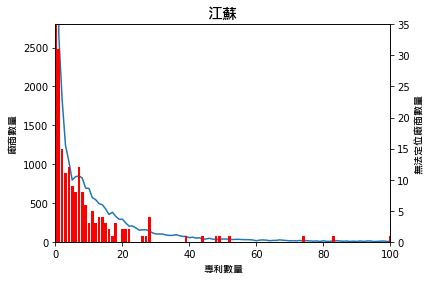

In [6]:
from matplotlib.font_manager import FontProperties
myfont = FontProperties(fname=r'C:\Windows\Fonts\msjhbd.ttc')
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(merge_df[merge_df['lat']!=0].groupby('專利數')['IPC'].count().index,merge_df[merge_df['lat']!=0].groupby('專利數')['IPC'].count())
ax1.set_title('江蘇',fontproperties=myfont,fontsize=15)
ax1.set_ylabel('廠商數量',fontproperties=myfont)
ax1.set_xlabel('專利數量',fontproperties=myfont)
ax1.set_xlim([0,100])
ax1.set_ylim([0,2800])
ax2 = ax1.twinx()
ax2.bar(merge_df[merge_df['lat']==''].groupby('專利數')['IPC'].count().index,merge_df[merge_df['lat']==''].groupby('專利數')['IPC'].count(),color='red')
ax2.set_ylim([0,35])
ax2.set_ylabel('無法定位廠商數量',fontproperties=myfont)


In [2]:
region = pd.read_excel(r'E:\paper\清理結果-新園區內外\江蘇_結果.xlsx',index_col=0)
region.fillna('',inplace=True)
corptype = ['有限','公司','责任','集团','股份','控股','总公司','分公司']
region['name_clean'] = region['name']
for k in corptype:
    region['name_clean'] = region['name_clean'].map(lambda x:re.sub(k,'',x))
region['name_clean'] = region['name_clean'].map(lambda x:re.sub(r'\(.*?\)','',x))
region['name_clean'] = region['name_clean'].map(lambda x:re.sub(r'\（.*?\）','',x))
region['name_clean'] = region['name_clean'].map(lambda x:re.sub(r'[\s+-─]','',x))
clean = region[region.duplicated(['name_clean'],keep=False)].sort_values(by=['企業名稱'])
patents = clean.groupby('name_clean')['專利數'].sum()
final = clean.drop('專利數',axis=1).merge(patents,left_on='name_clean',right_on='name_clean',how='left')
final.drop_duplicates(['name_clean'],keep='last',inplace=True)
region.drop_duplicates(['name_clean'],keep=False,inplace=True)
cleaned = pd.concat([region,final],ignore_index=True,sort=False)
located = cleaned[cleaned['lat']!='']
not_merge = located[located['企業名稱']=='']
print(len(not_merge['專利數']))
print(len(not_merge['專利數'])/len(located['專利數']))
print(len(not_merge[not_merge['專利數']>100]['專利數']))

7827
0.1537781445243428
163


In [3]:
not_merge.groupby('專利數')['IPC'].count()

專利數
1       1329
2        952
3        641
4        556
5        351
6        342
7        348
8        259
9        250
10       200
11       212
12       167
13       171
14       158
15       121
16       111
17       139
18       107
19        79
20        79
21        64
22        60
23        65
24        55
25        39
26        52
27        42
28        37
29        27
30        28
31        28
32        33
33        24
34        25
35        16
36        29
37        21
38        31
39        21
40        21
41        21
42        10
43        21
44         7
45         9
46        15
47        16
48         6
49        12
50        11
51        13
52        12
53        10
54        11
55        13
56        12
57        11
58        11
59        10
60         3
61         7
62         2
63         7
64         4
65         2
66         3
67         8
68         6
69         5
70         4
71         4
72         8
73         5
74         6
75         3
76         6
77      

In [4]:
not_merge[not_merge['專利數']>=1000].sort_values('專利數')

,法人代碼,企業名稱,地址,區域代碼,行業代碼,區域代碼_str,CPC,IPC,inpadoc同族,inpadoc同族个数,专利寿命（月）,专利类型,中国申请人区县,中国申请人地市,优先权信息,公开国别,公开（公告）号,公开（公告）日,发明人,合享价值度,同族国家,失效日,序号,引证专利,引证科技文献,...,简单同族个数,被引证专利,被引证国别(forward),被引证次数,链接到incoPat,申请人,name,address,完整地址,lat,lnt,南京,蘇州,無錫,常州,蘇州工業園,崑山,江陰,武進,泰州醫藥,徐州,早期園區,近期園區,專利數,name_clean
50816,,,,,,,,B66C23/88; B66C13/54,CN103010984A; CN103010984B,2,60,发明授权,[铜山],[徐州],,CN,CN103010984B,2015-09-16 00:00:00,米成宏; 马承杰; 徐春风,5,CN,2017-12-28 00:00:00,10227,CN203079600U; CN87206226U; JP2010174445A; CN201723032U; CN202509905U; CN202031411U; JP2005314974A,,...,2,,,0,到incoPat中查看\r\nCN103010984B,徐州重型机械有限公司,徐州重型机械有限公司,江苏省徐州市铜山路165号,1,34.2631,117.238,269.589607,452.602191,419.011474,371.448566,464.778947,471.968456,386.621790,384.191412,323.512570,9.258260,0,1,1425,徐州重型机械
50848,,,,,,,,B25B1/00; B25B1/16,CN103894942B; CN103894942A,2,,发明授权,[平江],[苏州],,CN,CN103894942B,2016-08-24 00:00:00,吉绍山; 陈国军; 程东华,8,CN,,2810,US1430260A; US2892369A; CN2832429Y; CN2810939Y; CN201158009Y; CN101462257A; CN2193232Y; US1799526A; GB195618A,,...,2,,,0,到incoPat中查看\r\nCN103894942B,苏州宝时得电动工具有限公司,苏州宝时得电动工具有限公司,江苏省苏州市工业园区东旺路18号,1,31.3196,120.771,217.081516,20.498346,47.059499,94.666496,0.000723,11.069652,79.914984,86.167375,144.564237,462.572261,1,0,1469,苏州宝时得电动工具


Text(0.5, 0, '專利數量')

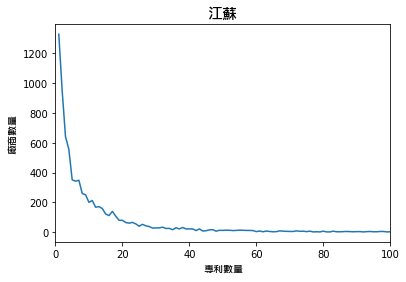

In [7]:
from matplotlib.font_manager import FontProperties
myfont = FontProperties(fname=r'C:\Windows\Fonts\msjhbd.ttc')
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(not_merge.groupby('專利數')['IPC'].count().index,not_merge.groupby('專利數')['IPC'].count())
ax1.set_title('江蘇',fontproperties=myfont,fontsize=15)
ax1.set_xlim([0,100])
ax1.set_ylabel('廠商數量',fontproperties=myfont)
ax1.set_xlabel('專利數量',fontproperties=myfont)

In [5]:
cleaned.to_excel(r'E:\paper\名稱merge\江蘇_結果.xlsx')

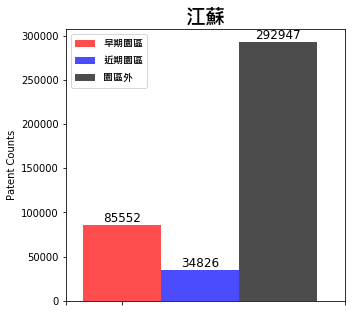

In [9]:
from matplotlib.font_manager import FontProperties
myfont = FontProperties(fname=r'C:\Windows\Fonts\msjhbd.ttc')
fig = plt.figure(figsize = (5,5))
ax1 = fig.add_subplot(111)
ax1.set_ylabel('Patent Counts')
bar1 = ax1.bar(1,merge_df[merge_df['早期園區']==1]['專利數'].sum(),alpha=0.7,width=0.35,color='r',label='早期園區')
bar2 = ax1.bar(1+0.35,merge_df[merge_df['近期園區']==1]['專利數'].sum(),alpha=0.7,width=0.35,color='b',label='近期園區')
bar3 = ax1.bar(1+0.7,merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].sum(),alpha=0.7,width=0.35,color='k',label='園區外')

plt.text(1, merge_df[merge_df['早期園區']==1]['專利數'].sum(), '%.0f' % merge_df[merge_df['早期園區']==1]['專利數'].sum(), ha='center', va= 'bottom',fontsize=12)  
plt.text(1.35, merge_df[merge_df['近期園區']==1]['專利數'].sum(), '%.0f' % merge_df[merge_df['近期園區']==1]['專利數'].sum(), ha='center', va= 'bottom',fontsize=12)  
plt.text(1.7, merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].sum(), '%.0f' % merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].sum(), ha='center', va= 'bottom',fontsize=12)  

plt.title('江蘇',fontproperties=myfont,fontsize=20)
plt.xticks([0.75,1,2],['','',''],fontproperties=myfont)
plt.legend(handles = [bar1,bar2,bar3], loc='upper left',prop=myfont)

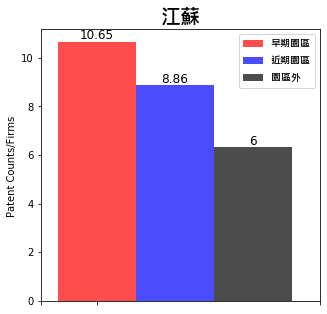

In [10]:
fig = plt.figure(figsize = (5,5))
ax1 = fig.add_subplot(111)
ax1.set_ylabel('Patent Counts/Firms ')
bar1 = ax1.bar(1,merge_df[merge_df['早期園區']==1]['專利數'].sum()/merge_df[merge_df['早期園區']==1]['專利數'].count(),alpha=0.7,width=0.35,color='r',label='早期園區')
bar2 = ax1.bar(1+0.35,merge_df[merge_df['近期園區']==1]['專利數'].sum()/merge_df[merge_df['近期園區']==1]['專利數'].count(),alpha=0.7,width=0.35,color='b',label='近期園區')
bar3 = ax1.bar(1+0.7,merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].sum()/merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].count(),alpha=0.7,width=0.35,color='k',label='園區外')

plt.text(1, (merge_df[merge_df['早期園區']==1]['專利數'].sum()/merge_df[merge_df['早期園區']==1]['專利數'].count()), '%.2f' % (merge_df[merge_df['早期園區']==1]['專利數'].sum()/merge_df[merge_df['早期園區']==1]['專利數'].count()), ha='center', va= 'bottom',fontsize=12)  
plt.text(1.35, (merge_df[merge_df['近期園區']==1]['專利數'].sum()/merge_df[merge_df['近期園區']==1]['專利數'].count()), '%.2f' % (merge_df[merge_df['近期園區']==1]['專利數'].sum()/merge_df[merge_df['近期園區']==1]['專利數'].count()), ha='center', va= 'bottom',fontsize=12)  
plt.text(1.7, (merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].sum()/merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].count()), '%.0f' % (merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].sum()/merge_df[(merge_df['近期園區']==0)&(merge_df['早期園區']==0)]['專利數'].count()), ha='center', va= 'bottom',fontsize=12)  

plt.title('江蘇',fontproperties=myfont,fontsize=20)
plt.xticks([0.75,1,2],['','',''],fontproperties=myfont)
plt.legend(handles = [bar1,bar2,bar3], loc='upper right',prop=myfont)